In [16]:
#1 Tarvittavat moduulit lisätty
import gmplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
from scipy.signal import butter, filtfilt

In [17]:
#2 Luetaan data
loca1 = pd.read_csv('Mittaus 1/Location.csv')
acce1 = pd.read_csv('Mittaus 1/Accelerometer.csv')
#acce1 = pd.read_csv('Mittaus 1/AccelerometerNew.csv', delimiter=';', decimal=',')
loca2 = pd.read_csv('Mittaus 2/Location.csv')
acce2 = pd.read_csv('Mittaus 2/Accelerometer.csv')
#acce2 = pd.read_csv('Mittaus 2/AccelerometerNew.csv', delimiter=';', decimal=',')

# Ei ollut vaatimus, mutta muutetaan time sarakkeen aika järkevämpään pvm+aika muotoon
loca1['time'] = pd.to_datetime(loca1['time'], unit='ns')
acce1['time'] = pd.to_datetime(acce1['time'], unit='ns')
loca2['time'] = pd.to_datetime(loca2['time'], unit='ns')
acce2['time'] = pd.to_datetime(acce2['time'], unit='ns')

display(loca1.tail())
display(acce1.tail())
display(loca2.tail())
display(acce2.tail())

,time,seconds_elapsed,bearingAccuracy,speedAccuracy,verticalAccuracy,horizontalAccuracy,speed,bearing,altitude,longitude,latitude
217,2023-10-05 12:17:15.776815000,131.460815,0,0,4.286681,5.341,1.277420,190.959152,38.300003,25.514726,65.069698
218,2023-10-05 12:17:16.345622800,132.029623,0,0,5.937324,5.593,1.271033,191.394928,38.500000,25.514721,65.069689
219,2023-10-05 12:17:16.900615700,132.584616,0,0,5.938589,5.969,1.269430,191.610321,38.500000,25.514716,65.069680
220,2023-10-05 12:17:17.455181000,133.139181,0,0,5.948719,6.251,1.270198,191.839310,38.500000,25.514713,65.069675
221,2023-10-05 12:17:18.009746400,133.693746,0,0,5.948719,6.493,1.270079,191.912033,38.500000,25.514709,65.069666


,time,seconds_elapsed,z,y,x
8441,2023-10-05 12:17:18.223827200,133.907827,5.114623,1.839526,-1.370973
8442,2023-10-05 12:17:18.239635500,133.923635,1.925411,1.976759,-1.019807
8443,2023-10-05 12:17:18.255474000,133.939474,0.877851,1.657148,-0.976474
8444,2023-10-05 12:17:18.271343000,133.955343,2.747669,0.726561,-1.049844
8445,2023-10-05 12:17:18.287151000,133.971151,4.901917,-0.585189,-0.953776


,time,seconds_elapsed,bearingAccuracy,speedAccuracy,verticalAccuracy,horizontalAccuracy,speed,bearing,altitude,longitude,latitude
190,2023-10-05 12:29:06.672846600,170.201847,10,20,5.683552,3.900,1.406635,0.410250,39.100002,25.514779,65.069208
191,2023-10-05 12:29:07.652636200,171.181636,10,20,5.693350,3.900,1.410321,0.511979,39.100002,25.514782,65.069221
192,2023-10-05 12:29:08.666674700,172.195675,10,20,5.703491,3.900,1.418154,0.583902,39.100002,25.514784,65.069236
193,2023-10-05 12:29:09.658575600,173.187576,10,20,5.713410,3.900,1.414708,0.596534,39.100002,25.514784,65.069248
194,2023-10-05 12:29:09.987000000,173.516000,0,0,4.796445,3.982,1.405612,0.592022,38.800003,25.514784,65.069250


,time,seconds_elapsed,z,y,x
10985,2023-10-05 12:29:10.699706400,174.228706,0.856920,0.194890,-0.155958
10986,2023-10-05 12:29:10.715514600,174.244515,-0.097509,-0.201992,-0.985660
10987,2023-10-05 12:29:10.731322600,174.260323,1.162950,-0.589215,-1.346831
10988,2023-10-05 12:29:10.747131000,174.276131,3.196170,-0.719898,-2.182938
10989,2023-10-05 12:29:10.762969300,174.291969,4.989938,-0.817301,-2.385845


In [18]:
#3 Piirretään reitit kahdelle eri kartalle

gmap = gmplot.GoogleMapPlotter(65.071195, 25.515131, 15, apikey="")

location_frame = loca1[['latitude','longitude']] #Luodaan Pandas data frame, jossa sarakkeina latitudi ja longitudi
location_list = location_frame.values.tolist() #Luodaan framesta lista
my_path = zip(*location_list)
gmap.plot(*my_path, color='#6495ED', edge_width=10)
#gmap.draw('route1.html') #Tallennetaan tiedostoon

#Sama toiselle reitille
location_frame2 = loca2[['latitude','longitude']]
location_list2 = location_frame2.values.tolist() 
my_path2 = zip(*location_list2)
gmap.plot(*my_path2, color='#00A36C', edge_width=10)
gmap.draw('route_combined.html')

In [19]:
#4 Määritellään funktio (Haversinen kaava), joka ottaa sisään alku- ja loppupisteen koordinaantit lon1, lat1, lon2, lat2
#ja palauttaa niiden välisen matkan

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points  on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers.
    return c * r #Palauttaa tämän

In [30]:
#5 Lasketaan matka Haversinen kaavaa käyttäen (vaikka se olisi jo valmiiksi datassa)

lat = loca1['latitude'] #Määritellään parametri lat, joka sisältää latitudin arvot
lon = loca1['longitude'] #Määritellään parametri lon, joka sisältää longitudin arvot
lat2 = loca2['latitude']
lon2 = loca2['longitude']

loca1['dist'] = np.zeros(lat.shape[0]) #Lisätään dataan nollasarake, johon kohta lasketaan pisteiden välinen etäisyys
loca2['dist'] = np.zeros(lat2.shape[0]) #Lisätään dataan nollasarake, johon kohta lasketaan pisteiden välinen etäisyys


for i in range(lat.shape[0]-1): #For-luuppi käy läpi datan toiseksi viimeiselle riville saakka
  loca1['dist'][i] = haversine(lon[i], lat[i],lon[i+1], lat[i+1])*1000 #Datan pisteiden i ja i + 1 välimatka metreissä

for i in range(lat2.shape[0]-1): 
  loca2['dist'][i] = haversine(lon2[i], lat2[i],lon2[i+1], lat2[i+1])*1000 


loca1['dist'][0] = 0
loca2['dist'][0] = 0
firstDistance = loca1['dist'].sum()
secondDistance = loca2['dist'].sum()
total_distance = firstDistance+secondDistance

firstAvgSpeed = (loca1['dist'].sum()/133.693746)#numero on ensimmäisen matkaan käytetty aika
secondAvgSpeed = (loca2['speed'].sum()/173.516000)#toisen matkan aika
totalAvgSpeed = (firstAvgSpeed+secondAvgSpeed)/2


#display(loca1.tail())
#display(loca2.tail())
print("1. matkan pituus:", firstDistance.round(2), 'metriä')
print("1. matkan keskinopeus:", firstAvgSpeed.round(2),'m/s')
print('')

print("2. matkan pituus:", secondDistance.round(2), 'metriä')
print("2. matkan keskinopeus:", secondAvgSpeed.round(2),'m/s')
print('')

print("Kokonaismatkan pituus:", total_distance.round(2), 'metriä')
print("Kokonaismatkan keskinopeus:", totalAvgSpeed.round(2),'m/s')

1. matkan pituus: 215.14 metriä
1. matkan keskinopeus: 1.61 m/s

2. matkan pituus: 299.46 metriä
2. matkan keskinopeus: 1.69 m/s

Kokonaismatkan pituus: 514.6 metriä
Kokonaismatkan keskinopeus: 1.65 m/s


C:\Users\Miikka.N\AppData\Local\Temp\ipykernel_13272\272293365.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loca1['dist'][i] = haversine(lon[i], lat[i],lon[i+1], lat[i+1])*1000 #Datan pisteiden i ja i + 1 välimatka metreissä
C:\Users\Miikka.N\AppData\Local\Temp\ipykernel_13272\272293365.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loca1['dist'][i] = haversine(lon[i], lat[i],lon[i+1], lat[i+1])*1000 #Datan pisteiden i ja i + 1 välimatka metreissä
C:\Users\Miikka.N\AppData\Local\Temp\ipykernel_13272\272293365.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

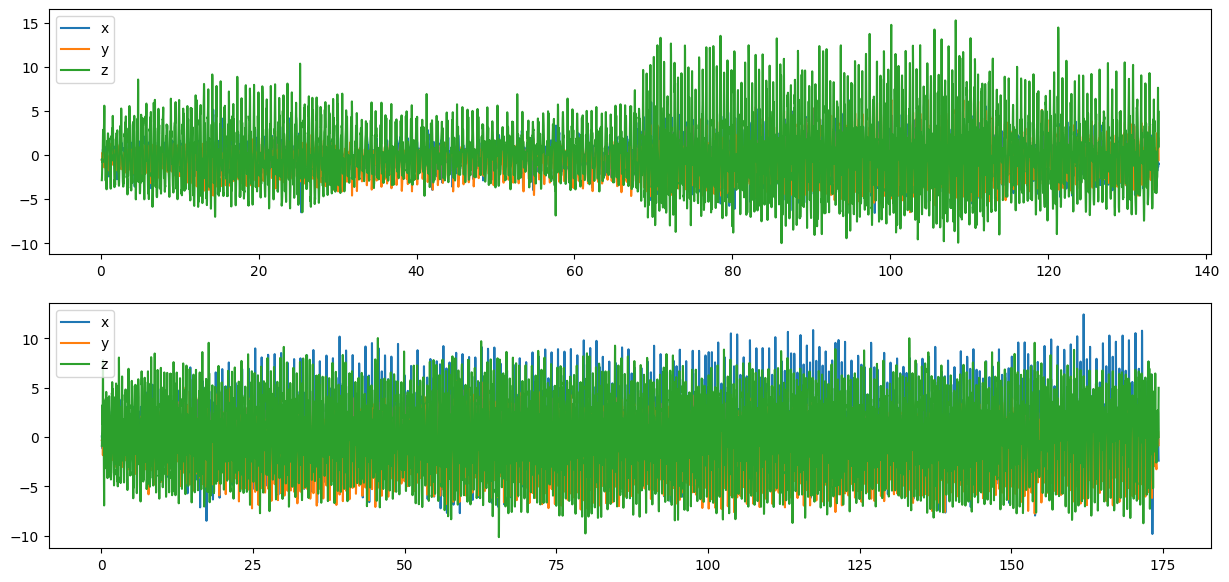

eka matkan x:  9603.94380273996
eka matkan y:  13128.732843633741
eka matkan z:  25602.166787147522

toka matkan x:  20519.267817724496
toka matkan y:  20631.800571769476
toka matkan z:  34774.29306125641


In [21]:
#5 askelten määrä, suodatettu
fig= plt.figure(figsize=(15,7))
plt.subplot(2,1,1)
plt.plot(acce1['seconds_elapsed'],acce1['x'])
plt.plot(acce1['seconds_elapsed'],acce1['y'])
plt.plot(acce1['seconds_elapsed'],acce1['z'])
plt.legend(['x','y','z'])

plt.subplot(2,1,2)
plt.plot(acce2['seconds_elapsed'],acce2['x'])
plt.plot(acce2['seconds_elapsed'],acce2['y'])
plt.plot(acce2['seconds_elapsed'],acce2['z'])
plt.legend(['x','y','z'])

plt.show()

print('eka matkan x: ',(acce1['x'].abs()).sum())
print('eka matkan y: ',(acce1['y'].abs()).sum())
print('eka matkan z: ',(acce1['z']).abs().sum())
print('')
print('toka matkan x: ',(acce2['x'].abs()).sum())
print('toka matkan y: ',(acce2['y'].abs()).sum())
print('toka matkan z: ',(acce2['z'].abs()).sum())

In [22]:
#6 Määritellään lowpass filtteri

def butter_lowpass_filter(data, cutoff, fs, nyq, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

#Datan soudatus
noisy_signal1 = acce1['z']
noisy_signal2 = acce2['z']

# Filtterin parametrit    
T1= acce1['seconds_elapsed'][len(acce1)-1] - acce1['seconds_elapsed'][0]    # Koko datan pituus
n1 = int(len(acce1['seconds_elapsed']))                        # Näytteiden lukumäärä
fs1 = n1/T1                                            # Näytteenottotaajuus (oletetaan vakioksi)

T2= acce2['seconds_elapsed'][len(acce2)-1] - acce2['seconds_elapsed'][0]    # Koko datan pituus
n2 = int(len(acce2['seconds_elapsed']))                        # Näytteiden lukumäärä
fs2 = n2/T2    

cutoff = 1/(0.5)                                    # Alipäästösuodattimen taajuus, Hz

nyq1 = 0.5 * fs1                                      # Nyquistin taajuus
nyq2 = 0.5 * fs2
order = 1                                           # Kertaluku

lowpass_filtered1 = butter_lowpass_filter(noisy_signal1, cutoff, fs1, nyq1, order)
lowpass_filtered2 = butter_lowpass_filter(noisy_signal2 ,cutoff, fs2, nyq2, order)

In [23]:
#7 Nyt lasketaan askeleet 
steps1 = 0
for i in range(lowpass_filtered1.shape[0]-1):
    if lowpass_filtered1[i]/lowpass_filtered1[i+1]<0:
        steps1 =steps1+0.5

print('1. matkan askelmäärä (suodatettu):',steps1)

steps2 = 0
for i in range(lowpass_filtered2.shape[0]-1):
    if lowpass_filtered2[i]/lowpass_filtered2[i+1]<0:
        steps2 =steps2+0.5

print('2. matkan askelmäärä (suodatettu):',steps2)
print('Askelia yhteensä (suodatettu):',steps1+steps2)

1. matkan askelmäärä (suodatettu): 257.5
2. matkan askelmäärä (suodatettu): 328.5
Askelia yhteensä (suodatettu): 586.0


c:\Users\Miikka.N\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


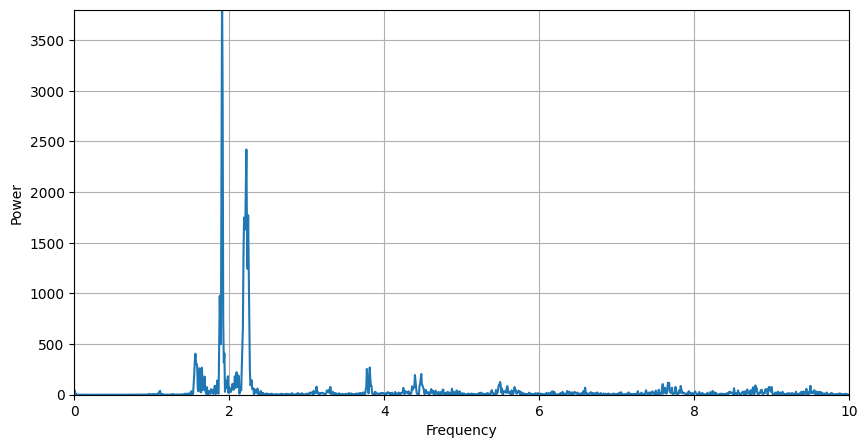

1. matkan askelmäärä (Fourier):  254.0
1. matkan keskimääräinen askelpituus: 0.85


In [27]:
#8 askelten määrä, Fourier, ensimmäinen matka

az = acce1['z'] #Acceleration
t = acce1['seconds_elapsed'] #Time
T= acce1['seconds_elapsed'][len(acce1)-1] - acce1['seconds_elapsed'][0]   # Sample Period
#Lasketaan kohinaisen signaalin Fourier-muunnos F

n = len(az)
F = np.fft.fft(az)
#Lasketaan tehospektri
PSD = F*np.conj(F)/n
freq = np.arange(n)*1/T # Tässä T on aika signaalin alusta loppuun
L = np.arange(1,np.floor(n/2),dtype = 'int')

fig = plt.figure(figsize = (10,5))
plt.plot(freq[L],PSD[L])
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.axis([0, 10, 0, 3800])
plt.grid()
plt.show()

max_power_f = freq[np.argmax(PSD[L])]
#print('Eniten tehoa sisältävä taajuus on ', max_power_f, 'Hz' )
print('1. matkan askelmäärä (Fourier): ', max_power_f*T)
print('1. matkan keskimääräinen askelpituus:', (firstDistance/(max_power_f*T)).round(2))

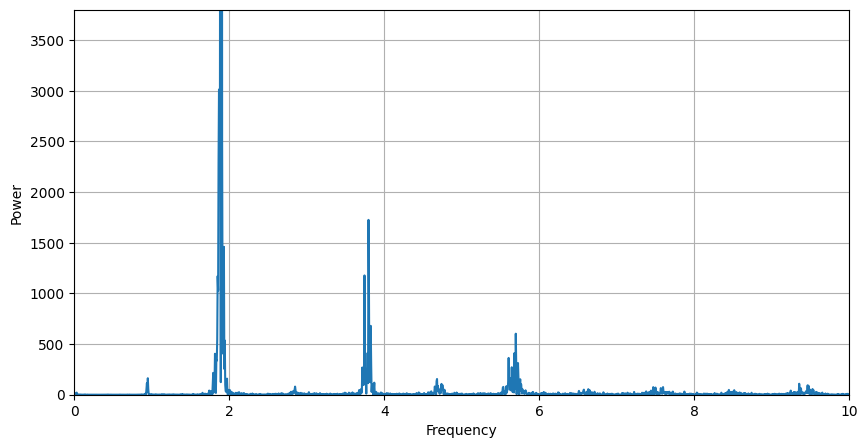

2. matkan askelmäärä(Fourier):  330.0
2. matkan keskimääräinen askelpituus: 0.91

Askelia yhteensä (Fourier):  584.0
Keskimääräinen askelpituus: 0.88


In [28]:
#9 askelten määrä, Fourier, toinen matka

az = acce2['z'] #Acceleration
t = acce2['seconds_elapsed'] #Time
T= acce2['seconds_elapsed'][len(acce2)-1] - acce2['seconds_elapsed'][0]   # Sample Period
#Lasketaan kohinaisen signaalin Fourier-muunnos F

n = len(az)
F = np.fft.fft(az)
#Lasketaan tehospektri
PSD = F*np.conj(F)/n
freq = np.arange(n)*1/T # Tässä T on aika signaalin alusta loppuun
L = np.arange(1,np.floor(n/2),dtype = 'int')

fig = plt.figure(figsize = (10,5))
plt.plot(freq[L],PSD[L])
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.axis([0, 10, 0, 3800])
plt.grid()
plt.show()

max_power_f = freq[np.argmax(PSD[L])]
#print('Eniten tehoa sisältävä taajuus on ', max_power_f, 'Hz' )
print('2. matkan askelmäärä(Fourier): ', max_power_f*T)
print('2. matkan keskimääräinen askelpituus:', (secondDistance/(max_power_f*T)).round(2))
print('')
print('Askelia yhteensä (Fourier): ', max_power_f*T+254)
print('Keskimääräinen askelpituus:', (total_distance/((max_power_f*T)+254)).round(2))